<a href="https://colab.research.google.com/github/nazaribih/ML_intro/blob/main/Diabetes_detection_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*Diabetes Detection - Feature Engineering*

Nazarii Bihniak, Katarzyna Rogalska

## Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports and data loading

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# df read from Colab/github
df = pd.read_csv("/content/diabetes_012_health_indicators_BRFSS2015.csv")

# df read from Google Drive if mounted - Nazarii
# df = pd.read_csv("/content/drive/MyDrive/ml_diabetes/diabetes_012_health_indicators_BRFSS2015.csv")

# df read from Google Drive if mounted - Kasia
# df = pd.read_csv("/content/drive/MyDrive/CSV_ML/diabetes_012_health_indicators_BRFSS2015.csv")

## Train Validation Test Split

In [ ]:
from sklearn.model_selection import train_test_split

y = np.array(df['Diabetes_012'])
X = df.drop(['Diabetes_012'], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, stratify=Y_val, test_size=0.3, random_state=42)


test_df = X_test
test_df['Diabetes_012']=Y_test

test_df.to_csv("Test_DataFrame_Diabetes.csv", index=False)

val_df = X_val
val_df['Diabetes_012']= Y_val

val_df.to_csv('Validation_DataFrame_Diabetes.csv', index=False)

train_df = X_train
train_df['Diabetes_012']=Y_train

train_df.to_csv("Training_DataFrame_Diabetes.csv", index=False)

## Feature importance methods (original df)

**For categorical features we will use:**
* Chi-Squared Test - specifically for categorical variables!
* KBest
* Mutual Information
* RandomForest feature importance

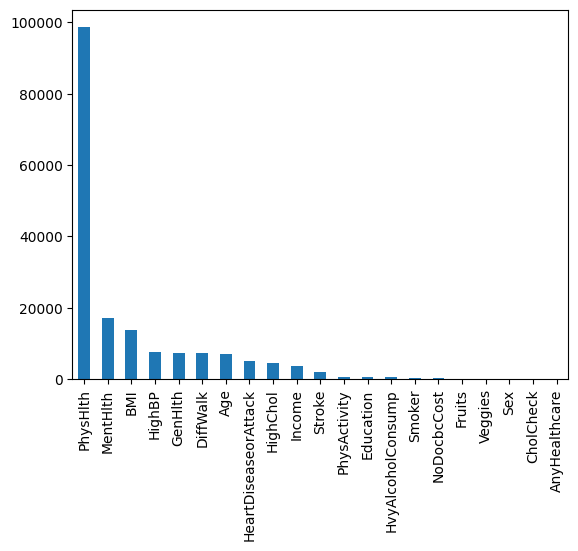

In [ ]:
# chi2
from sklearn.feature_selection import chi2

X= train_df.drop(columns=['Diabetes_012'])
y=train_df['Diabetes_012']

chi_scores = chi2(X,y)
chi_values = pd.Series(chi_scores[0], X.columns) # the higher the score,the  higher the importance
chi_values.sort_values(ascending=False, inplace=True)
chi_values.plot.bar()

chi_before_binning=chi_values

* We can see that the most important features are Physical and mental health (we wanted to drop them because of one value dominance so maybe this is an error ?)
* the least important features are AnyHealthCare, Cholcheck (which we will drop because we have results of chol check in HighChol column), sex, veggies, fruits
* we had similar observations from EDA

In [ ]:
# K best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
k_best = SelectKBest(score_func=f_classif, k=10)
k_best_fit = k_best.fit(X,y)
X.columns[k_best_fit.get_support(indices=True)].tolist()

['HighBP',
 'HighChol',
 'BMI',
 'HeartDiseaseorAttack',
 'GenHlth',
 'PhysHlth',
 'DiffWalk',
 'Age',
 'Education',
 'Income']

* similar results as from chi2

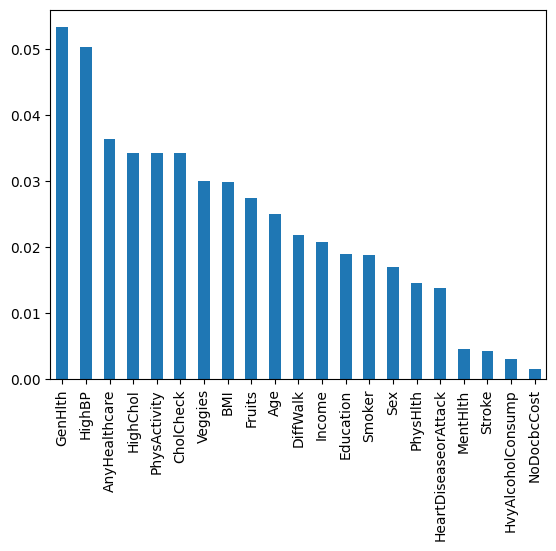

In [ ]:
# Mutual information
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X,y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False).plot.bar()

MI_before_binning=mutual_info

* results are slightly different from the previous ones
* AbyHealthcare,Fruits, Veggies,  which had no importance, is quite high here (what does it mean?)
* Many features that were 'important' in other metrics are also important using mutual information


In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

X=train_df.drop(columns='Diabetes_012')
y=train_df['Diabetes_012']
forest=RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X,y)
importances = forest.feature_importances_

feature_names = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Feature binning

In [ ]:
def group_by_BMI(BMI):
    if BMI < 18.5:
        return 'Underweight'
    elif  BMI<25:
        return 'NormalWeight'
    elif BMI< 30:
        return 'Overweight'
    else:
        return 'Obesity'

def change_education_to_name(Education):
    if Education in [1,2]:
        return 'PrimaryEducation'
    elif Education in [3,4]:
        return 'HighSchoolEducation'
    else:
        return 'CollageEducation' #collage not finished and bachelors degrees

def group_income(Income):
    if Income<=3:
        return '<=15000$_income'
    elif Income<=5:
        return '15000$-25000$_income'
    elif Income<=7:
        return '25000$-50000$_income'
    else:
        return '50000$+_income'
def group_age(Age):
    if Age in[1,2,3]:
        return 'YoungAdult'
    elif Age in[4,5,6,7,8]:
        return 'Adult'
    else:
        return 'Elderly'


In [ ]:
def first_binning(X):
  A= X.copy()
  A['BMI']=A['BMI'].apply(group_by_BMI)
  A['Education'] = A['Education'].apply(change_education_to_name)
  A['Income']=A['Income'].apply(group_income)
  A['Age']=A['Age'].apply(group_age)
  return A

In [ ]:
from sklearn.preprocessing import FunctionTransformer
first_transformer = FunctionTransformer(first_binning)


In [ ]:
from sklearn.preprocessing import LabelEncoder
def label_encoding(X):
  A= X.copy()
  label_encoder = LabelEncoder()
  A['BMI'] = label_encoder.fit_transform(A['BMI'])
  A['Age'] = label_encoder.fit_transform(A['Age'])
  A['Income'] = label_encoder.fit_transform(A['Income'])
  A['Education'] = label_encoder.fit_transform(A['Education'])
  return A

In [ ]:
second_transformer = FunctionTransformer(label_encoding)

**Feature importance after first  binning**

In [ ]:
# chi2

train_df_binned1 = first_binning(X_train) # wywołanie funkcji transofrmacji
train_df_binned_labeled = label_encoding(train_df_binned1)

X_after_binning= train_df_binned_labeled.drop(columns=['Diabetes_012'])
y_after_binning=train_df_binned_labeled['Diabetes_012']

chi_scores = chi2(X_after_binning,y_after_binning)
chi_values = pd.Series(chi_scores[0], X_after_binning.columns) # the higher the score,the  higher the importance
chi_values.sort_values(ascending=False, inplace=True)

print("Chi scores before binning vs after binning:")
print("BMI:", chi_before_binning['BMI'] ,"VS" ,chi_values["BMI"])
print("Age:", chi_before_binning['Age'], "VS", chi_values["Age"])
print("Education:", chi_before_binning['Education'], "VS", chi_values['Education'])
print("Income:", chi_before_binning['Income']," Vs ", chi_values["Income"])


Chi scores before binning vs after binning:
BMI: 13860.484948725429 VS 185.73689075667676
Age: 7113.886132861852 VS 49.91950646150602
Education: 589.7624312460346 VS 1702.0804603979095
Income: 3759.8551882227644  Vs  0.23412971549633757


* The importance of BMI, Age, Income significantly decreased after binning
* the importance of education increased: 589 before, now: 1702

* in this metric the importance of BMI, Age, Income slighlty increased opposed to chi2
* the importance of Education after binning dropped

**The first binning wasn't succesfull, Maybe the original categories in our data shouldn't be changed to bigger bins**

Let's try binning BMI and Age the other way because they have the most unique values, and leave the other ones (they are already categorical)

In [ ]:
def second_binning(X):
  A=X.copy()
  A['BMI'] = pd.qcut(A['BMI'], q=10, labels=False)
  A['Age'] = pd.qcut(A['Age'], q=7 ,labels=[0,1,2,3,4,5,6])
  return A

In [ ]:
third_transformer = FunctionTransformer(second_binning)

In [ ]:
train_df_binned2 = second_binning(train_df)

In [ ]:
# chi2 after binning BMI and Age
X_after_binning2= train_df_binned2.drop(columns=['Diabetes_012'])
y_after_binning2=train_df_binned2['Diabetes_012']

chi_scores = chi2(X_after_binning2,y_after_binning2)
chi_values = pd.Series(chi_scores[0], X_after_binning2.columns) # the higher the score,the  higher the importance
chi_values.sort_values(ascending=False, inplace=True)

print("Chi scores before binning vs after binning:")
print("BMI:", chi_before_binning['BMI'] ,"VS" ,chi_values["BMI"])
print("Age:", chi_before_binning['Age'] ,"VS" ,chi_values["Age"])

Chi scores before binning vs after binning:
BMI: 13860.484948725429 VS 20241.676656833166
Age: 7113.886132861852 VS 7818.471902377956


* the importance of BMI and Age after new binning increased in chi2

## Adding new features

Let's add some new features to the data frame after 2 binning and see their importance

In [ ]:
def add_new_features_drop_some(X):
  A=X.copy()
  A['BloodHealth']= A['HighBP'] + A['HighChol']
  A['HeartHealth'] = A['Stroke'] + A['HeartDiseaseorAttack']
  A['Diat'] = A['Fruits'] + A['Veggies']
  A['BMI_GenHlth'] = A['BMI']* A['GenHlth']
  A= A.drop(columns =['CholCheck', 'PhysHlth','MentHlth', "GenHlth"]) # drop reasons:  CholCheck - irrelevant we have HighChol as a result of cholCheck,
                                                                    # PhysHlth,MentHlth - from Eda plots we know that most of the values are 0.0 and we have 30 categories there
                                                                    #GenHlth - after creating a new column GenHlth correlation is very high with it
  return A

In [ ]:
fourth_transofrmer = FunctionTransformer(add_new_features_drop_some)

In [ ]:
train_df_new_features = add_new_features_drop_some(train_df_binned2)  # adding to binned 2 because we have to bin and the 2nd binning was more succesfull

<Axes: >

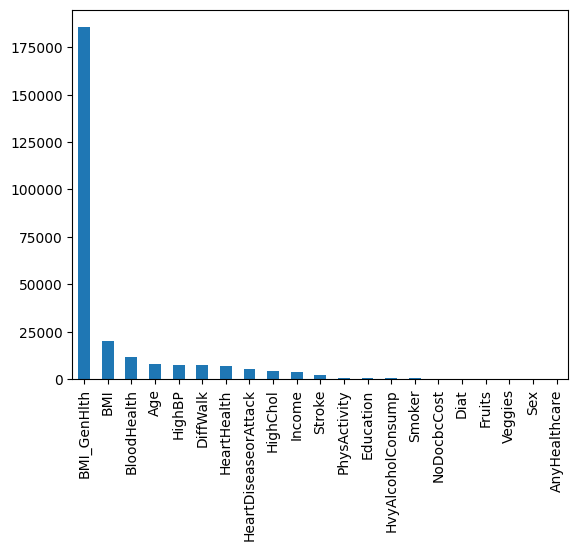

In [ ]:
#feature importance after adding new features
X_new= train_df_new_features.drop(columns=['Diabetes_012'])
y_new=train_df_new_features['Diabetes_012']

chi_scores = chi2(X_new,y_new)
chi_values = pd.Series(chi_scores[0], X_new.columns) # the higher the score,the  higher the importance
chi_values.sort_values(ascending=False, inplace=True)

chi_values.plot.bar()

* We can see that BMi_GenHealth, bloodHealth and HeartHealth have a significant importance, Diat and stimulants are not so dependent on the target

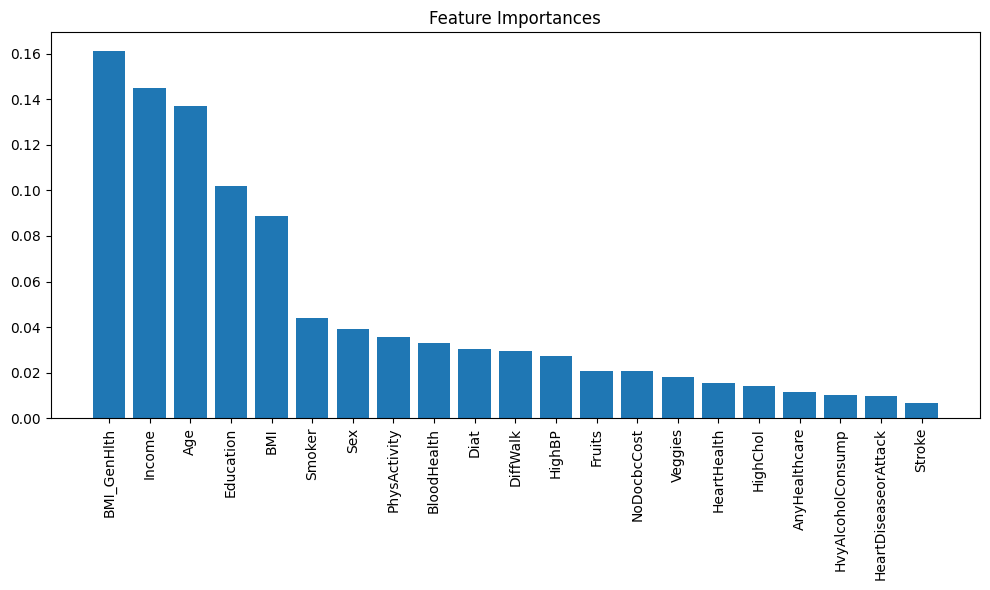

In [ ]:
#random forest feature importance
X=train_df_new_features.drop(columns='Diabetes_012')
y=train_df_new_features['Diabetes_012']
forest=RandomForestClassifier(n_estimators=200, random_state=1)
forest.fit(X,y)
importances = forest.feature_importances_

feature_names = X.columns
indices = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

* the importance of Age and BMi remains the same
* We can see a quite high importance of new columns

Let's reduce dimensions and select only 10 best columns using SelectKBest

In [ ]:
X= train_df_new_features.drop(columns='Diabetes_012')
y=train_df_new_features['Diabetes_012']

k_best = SelectKBest(score_func=f_classif, k=10)
k_best_fit = k_best.fit(X,y)
X.columns[k_best_fit.get_support(indices=True)].tolist()

['HighBP',
 'HighChol',
 'BMI',
 'HeartDiseaseorAttack',
 'DiffWalk',
 'Age',
 'Income',
 'BloodHealth',
 'HeartHealth',
 'BMI_GenHlth']

In [ ]:
train_df_10Best = train_df_new_features[['HighBP',
 'HighChol',
 'BMI',
 'HeartDiseaseorAttack',
 'DiffWalk',
 'Age',
 'Income',
 'BloodHealth',
 'HeartHealth',
 'BMI_GenHlth']]

## DataFrames to test on

**At this point we have a few different data frames that we can use in our models (with their transormation functions)**

1) **train_df_binned_categorical** - Income,Education,BMI,Age binned and categorical encoding (first_tranfosmer)

2) **train_df_binned_labeled** - the same df as before but label encoding (second_transformer)

3) **train_df_binned2**  - only BMI and Age binned, label encoding (third_transformer)

4) **train_df_new_features** - train_df_binned2 with new columns and dropped irrelevant ones (fourth_transformer)

6) **train_df_10Best** - train_df_dropped with selectes 10 best columns

Also to add some one hot encoded dataframes


## Fist approach to modeling

In [ ]:
from copy import deepcopy
X_test1 = deepcopy(X_test)
X_train1 = deepcopy(X_train)
X_val1 = deepcopy(X_val)

X_test1.drop(columns='Diabetes_012',inplace=True)
X_train1.drop(columns='Diabetes_012',inplace=True)
X_val1.drop(columns='Diabetes_012',inplace=True)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.metrics import accuracy_score
def fit_model_with_pipe_accuracy(pipe, X_train = X_train1, y_train = Y_train, X_test= X_test1, y_test= Y_test):
  pipe.fit(X_train, y_train)
  predictions = pipe.predict(X_test)
  real_vals = y_test
  return accuracy_score(predictions,real_vals)

In [ ]:
from sklearn.metrics import confusion_matrix
def fit_model_with_pipe_confusion_matrix(pipe, X_train = X_train1, y_train = Y_train, X_test= X_test1, y_test= Y_test):

  pipe.fit(X_train, y_train)
  predictions = pipe.predict(X_test)
  real_vals = y_test

  return confusion_matrix(real_vals,predictions)

In [ ]:
pipe_forest1 = Pipeline([("Transformer", fourth_transofrmer),
              ('RandomForest', RandomForestClassifier(random_state=42))]) #first pipeline for df with new features

print(fit_model_with_pipe_accuracy(pipe_forest1))
print(fit_model_with_pipe_confusion_matrix(pipe_forest1))

1.0
[[18416    39   779]
 [  361     1    55]
 [ 2481    11   689]]


**Random Forest**

In [ ]:
pipe_forest1 = Pipeline([("Transformer", fourth_transofrmer), ('RandomForest', RandomForestClassifier(random_state=42))]) #first pipeline for df with new features
print(fit_model_with_pipe_accuracy(pipe_forest1))
print(fit_model_with_pipe_confusion_matrix(pipe_forest1))

0.8368079887876664
[[18416    39   779]
 [  361     1    55]
 [ 2481    11   689]]


**Decision tree**

In [ ]:
pipe_forest1 = Pipeline([("Transformer", fourth_transofrmer), ('DecisionTree', DecisionTreeClassifier(random_state=42))]) #first pipeline for df with new features
print(fit_model_with_pipe_accuracy(pipe_forest1))
print(fit_model_with_pipe_confusion_matrix(pipe_forest1))

0.775052557813595
[[16703   386  2145]
 [  312    18    87]
 [ 2091   115   975]]


* Accuracy score is not a good method for imbalance classes!!!
* In our case the confusion matrix shows which are bestly predicted

TO DO:

find different evaluation techniques,

try different models,

try different data frames